# Community detection

## Utils

In [ ]:
!pip install python-louvain
!pip install scikit-network

In [1]:
from community import community_louvain
import networkx as nx
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms import community
from sknetwork.hierarchy import Paris, cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_dendrogram
from sknetwork.hierarchy.postprocess import cut_straight

import itertools
import numpy as np
from operator import itemgetter
import pandas as pd
import re

from google.colab import files
from IPython.display import SVG
import matplotlib.pyplot as plt

In [2]:
def network_from_edges(edges):
  dict_edges = {}
  for ind in range(len(edges)):
    if edges.iloc[ind,2] > 10:
      dict_edges[(edges.iloc[ind,0], edges.iloc[ind,1])] = edges.iloc[ind,2]
  net = pd.DataFrame.from_dict(dict_edges,orient='index')
  net.columns = ["weight"]
  net.sort_values(by="weight",inplace=True, ascending=False)
  return dict_edges, net


def get_graph(network):
  G = nx.Graph()
  for edge in network:
      #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
      G.add_edge(edge[0], edge[1], weight=network[edge])
  
  #G.add_weighted_edges_from(up_weighted, weight='weight')
  return G


def extract_text(df):       #extract the text from the tweets and RT
                            #works ONLY on .csv file
  list_strings = []
  for index in range(len(df)):
    text = df.loc[index]['text']                          #if it is nor trucated nor a RT  i take "text"
    string = -1
    if (df.loc[index,"truncated"] == True):                 #if it is trucated I take "extended_tweet"
        string = df.loc[index,"extended_tweet"]
    if type(df.loc[index,"retweeted_status"]) != float:     #if it is a RT I take retweeted_status
        string = df.loc[index,"retweeted_status"]
    if type(string) == str :
        if(re.search('full_text\':(.+?)https',string) != None):     #if I find "full_text"
          s = re.search('full_text\':(.+?)https',string).group(1)
        if(re.search('text\':(.+?)https',string)!= None):
          s = re.search('text\':(.+?)https',string).group(1)
        else: 
          continue
        list_strings.append(s)
    else:
      list_strings.append(text)

  return list_strings


def frequency_dictionary(df):
  unique_words = {}

  for row in df:
    for word in row.split():
      #if the word is encountered for the first time add to dict as key and set its value to 0
      unique_words.setdefault(word,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
      unique_words[word] += 1

  return unique_words


def adj_matrix(node_list, edge_list):   

  words = sorted(list(node_list['Id']))

  A = pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words)
  print('A shape: ', A.shape)
  for row in range(len(edge_list)):
    if row%1000==0:
      print(str(round(row/1000)) + '/' + str(round(len(edge_list)/1000)))
    word1 = edge_list.iloc[row, 0]
    word2 = edge_list.iloc[row, 1]
    weight = edge_list.iloc[row, 2]
    A[word1, word2] = weight
    A[word2, word1] = weight
  print('A shape: ', A.shape)
  return A

In [3]:
def community_check(community, dict_1, dict_2, G_1, G_2, thr):
  sum_1 = 0
  sum_2 = 0
  sum_12 = 0
  for key in community:
    if (key in list(dict_1.keys())) and (key in list(dict_2.keys())):
      if dict_1[key] / sum(list(dict_1.values())) - dict_2[key] / sum(list(dict_2.values())) > thr:
        sum_1 += 1
      elif dict_1[key] / sum(list(dict_1.values())) - dict_2[key] / sum(list(dict_2.values())) < -thr:
        sum_2 += 1  
      else:
        sum_12 += 1 
    elif key in list(G_1.nodes()):
      sum_1 += 1
    elif key in list(G_2.nodes()):
      sum_2 += 1
  return sum_1, sum_2, sum_12

In [4]:
# Functions for measuring the quality of a partition (into communities).

def compute_metrics(G, partition):

  # Returns the coverage of a partition.
  coverage = community.coverage(G, partition)

  # Returns the coverage and performance of a partition of G.
  quality = community.partition_quality(G, partition)

  performance = community.performance(G, partition)

  # Returns the modularity of the given partition of the graph.
  modularity = community.modularity(G, partition)

  print("Coverage: ", coverage)
  # print("Quality: ", quality) # Coverage and performance
  print("Performance: ", performance)
  print("Modularity: ", modularity)

  return coverage, quality, performance, modularity


In [5]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=2.)

    pos_nodes = _position_nodes(g, partition, scale=2.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.circular_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

# PageRank Networks

## **All periods**

### Load data

In [155]:
China = pd.read_csv('/content/China.csv')
USA = pd.read_csv('/content/USA.csv',)

edges = pd.read_csv('/content/edgelist_China_USA.csv')
edges_China = pd.read_csv('/content/edgelist_China.csv')
edges_USA = pd.read_csv('/content/edgelist_USA.csv')

nodes = pd.read_csv('/content/nodelist_China_USA.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [156]:
# Remove search keywords: coronavirus, covid, vaccine
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [157]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  506
Edges:  10561
Is connected:  True

China:
Words:  16883

USA:
Words:  33525


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [13]:
community_bipart = community.kernighan_lin_bisection(G, weight='weight')

In [14]:
print(community_bipart[0])
print(community_bipart[1])

{'president', 'continue', 'health', 'debate', 'africa', 'response', 'analysis', 'outbreak', 'virus', 'new', 'total', 'day', 'resident', 'leave', 'remain', 'call', 'support', 'surpass', 'outside', 'nominee', 'pandemic', 'across', 'concern', 'battle', 'record', 'house', 'shot', 'become', 'week', 'single', 'declare', 'due', 'start', 'increase', 'recover', 'data', 'hong', 'hospital', 'antibody', 'set', 'see', 'doctor', 'third', 'travel', 'global', 'bring', 'france', 'foreign', 'year', 'lead', 'australia', 'may', 'staff', 'mask', 'spike', 'reach', 'contain', 'give', 'two', 'election', 'early', 'face', 'back', 'variant', 'pause', 'include', 'state', 'six', 'rise', 'center', 'wave', 'make', 'discharge', 'nation', 'effective', 'toll', 'joe', 'develop', 'tell', 'presidential', 'people', 'since', 'top', 'nearly', 'epicenter', 'announce', 'worker', 'lady', 'commission', 'province', 'live', 'month', 'supply', 'close', 'long', 'united', 'mark', 'many', 'quarantine', 'least', 'study', 'control', 'ca

In [15]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [16]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  41 %
USA:  52 %
China&USA:  8 %

China:  26 %
USA:  64 %
China&USA:  10 %


**Metrics**

In [17]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.7092131426948206
Performance:  0.535577035964466
Modularity:  0.008190769033489028


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [18]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [19]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['head', 'president', 'debate', 'analysis', 'response', 'job', 'remain', 'nominee', 'soon', 'house', 'week', 'add', 'talk', 'game', 'british', 'worry', 'claim', 'doctor', 'relief', 'breaking', 'california', 'vice', 'staff', 'provide', 'person', 'give', 'election', 'statement', 'aid', 'today', 'diagnose', 'ahead', 'question', 'joe', 'tell', 'presidential', 'stock', 'top', 'announce', 'post', 'court', 'lady', 'mark', 'likely', 'exclusive', 'condition', 'chief', 'hope', 'trump', 'release', 'mike', 'office', 'hold', 'right', 'critical', 'vote', 'still', 'team', 'leader', 'rule', 'contact', 'next', 'push', 'small', 'general', 'base', 'share', 'think', 'test', 'come', 'member', 'minister', 'senior', 'need', 'symptom', 'negative', 'much', 'official', 'good', 'ask', 'severe', 'penny', 'director', 'several', 'event', 'move', 'former', 'republican', 'prime', 'adviser', 'less', 'well', 'secretary', 'change', 'experience', 'campaign', 'source', 'bill', 'white', 'result', 'limit', 'diagnosis', 'ret

In [20]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  25 %
USA:  70 %
China&USA:  5 %

Community:  1
China:  52 %
USA:  41 %
China&USA:  7 %

Community:  2
China:  41 %
USA:  46 %
China&USA:  13 %

Community:  3
China:  21 %
USA:  69 %
China&USA:  9 %

Community:  4
China:  23 %
USA:  66 %
China&USA:  11 %

Community:  5
China:  10 %
USA:  70 %
China&USA:  20 %



**Metrics**

In [21]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.3682416437837326
Performance:  0.7754705905373146
Modularity:  0.2218578515648647


In [22]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [24]:
community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [25]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['university', 'student', 'data', 'among', 'show', 'trial', 'make', 'vaccinate', 'track', 'risk', 'drug', 'medicine', 'industry', 'get', 'possible', 'woman', 'deliver', 'use', 'end', 'food', 'billion', 'big', 'part', 'find', 'may', 'exclusive', 'sign', 'company', 'year', 'old', 'clinical', 'scientist', 'safe', 'long', 'receive', 'follow', 'volunteer', 'strong', 'man', 'early', 'develop', 'urge', 'way', 'produce', 'study', 'child', 'effective', 'appear', 'term', 'stage', 'result', 'side', 'drive', 'experimental', 'batch', 'approve', 'candidate', 'dose', 'vaccination', 'population', 'shot', 'illness', 'potential', 'age', 'young', 'free', 'effect', 'blood', 'clot', 'johnson', 'adult', 'rare', 'agency', 'link', 'regulator', 'safety', 'antibody', 'pause', 'researcher', 'want', 'severe', 'problem', 'committee', 'federal', 'benefit']
['cruise', 'ship', 'japan', 'allow', 'leave', 'evacuate', 'despite', 'quarantine', 'passenger', 'fear']
['continue', 'reach', 'fall', 'case', 'million', 'death',

In [26]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  22 %
USA:  69 %
China&USA:  8 %

Community:  1
China:  10 %
USA:  70 %
China&USA:  20 %

Community:  2
China:  38 %
USA:  50 %
China&USA:  13 %

Community:  3
China:  46 %
USA:  46 %
China&USA:  8 %

Community:  4
China:  70 %
USA:  30 %
China&USA:  0 %

Community:  5
China:  47 %
USA:  45 %
China&USA:  8 %

Community:  6
China:  23 %
USA:  70 %
China&USA:  7 %



**Metrics**

In [27]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.38670580437458574
Performance:  0.7539545258873713
Modularity:  0.22039083457823821


In [28]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [30]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

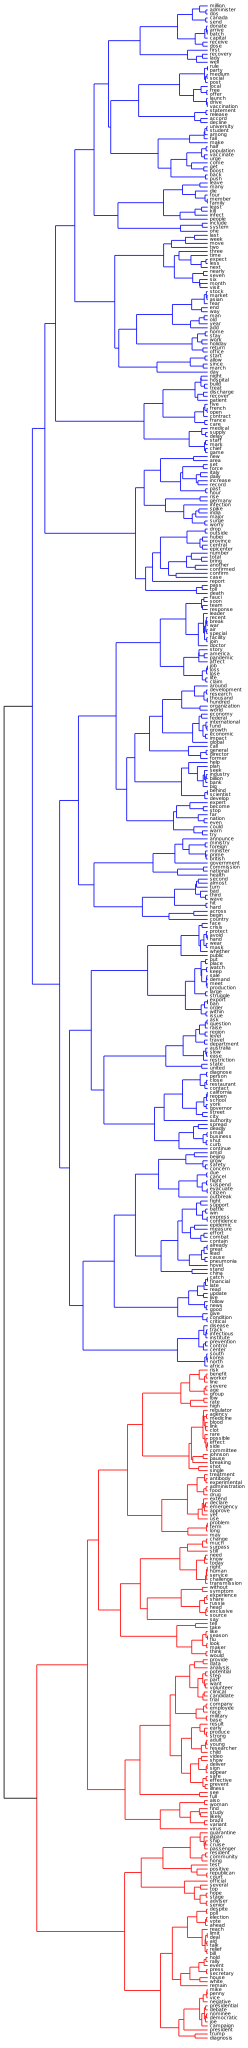

In [31]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2_all_periods')
SVG(image)

**Metrics**

In [32]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [33]:
_ = compute_metrics(G, community_dend)

Coverage:  0.6513587728434808
Performance:  0.4681250733769029
Modularity:  0.11985278617333636


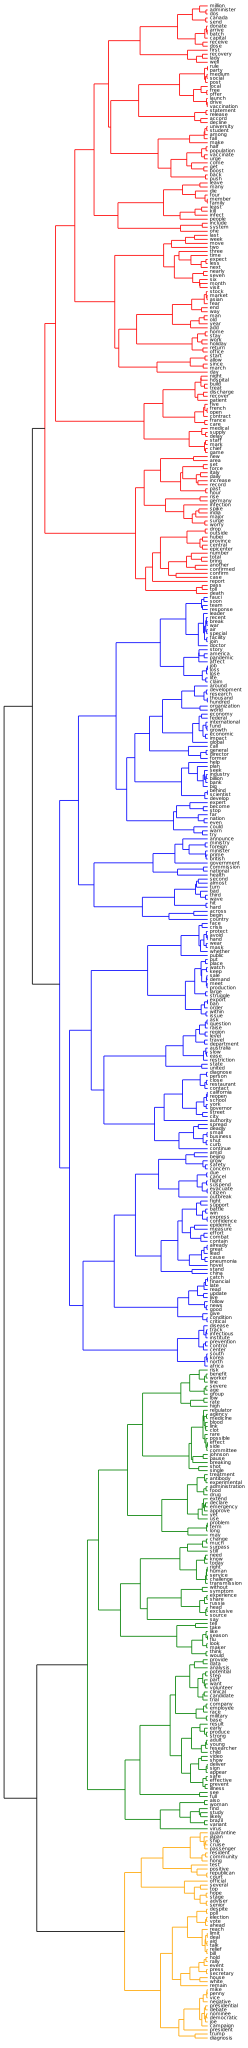

In [34]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4_all_periods')
SVG(image)

**Metrics**

In [35]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [36]:
_ = compute_metrics(G, community_dend)

Coverage:  0.400151500804848
Performance:  0.6943059523343639
Modularity:  0.16613997919760423


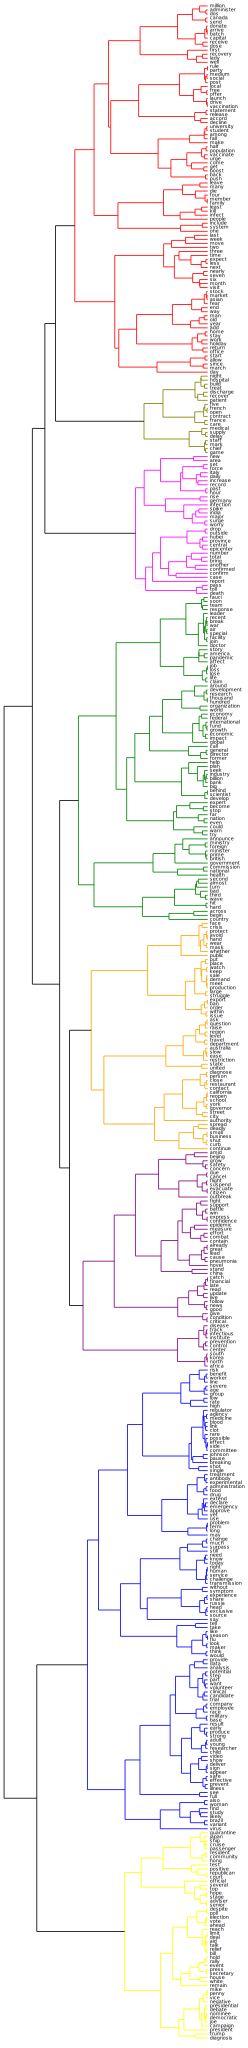

In [37]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8_all_periods')
SVG(image)

**Metrics**

In [38]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [39]:
_ = compute_metrics(G, community_dend)

Coverage:  0.25319572010226304
Performance:  0.8095566078346965
Modularity:  0.17309283179628146


### Girvan_Newman: not working!

In [40]:
community_gn = community.girvan_newman(G)
k = 2
i = 1
for comm in itertools.islice(community_gn, k):
  if i == 2:
    for x in range(len(comm)):
      print(sorted(comm[x]))
  i += 1

['accord', 'across', 'add', 'administer', 'administration', 'adult', 'adviser', 'affect', 'africa', 'age', 'agency', 'ahead', 'aid', 'air', 'allow', 'almost', 'already', 'also', 'america', 'amid', 'among', 'analysis', 'announce', 'another', 'antibody', 'appear', 'approve', 'area', 'around', 'arrive', 'asian', 'ask', 'australia', 'authority', 'avoid', 'back', 'bad', 'ban', 'bank', 'base', 'batch', 'battle', 'become', 'begin', 'behind', 'beijing', 'benefit', 'big', 'bill', 'billion', 'blood', 'boost', 'brazil', 'break', 'breaking', 'bring', 'british', 'build', 'business', 'california', 'call', 'campaign', 'canada', 'cancel', 'candidate', 'capital', 'care', 'case', 'catch', 'cause', 'center', 'central', 'challenge', 'change', 'chief', 'child', 'china', 'citizen', 'city', 'claim', 'clinical', 'close', 'clot', 'combat', 'come', 'commission', 'committee', 'community', 'company', 'concern', 'condition', 'confidence', 'confirm', 'confirmed', 'contact', 'contain', 'continue', 'contract', 'contr

In [ ]:
# VERY HEAVY COMPUTATION
def most_central_edge(G):
  centrality = betweenness(G, weight="weight")
  return max(centrality, key=centrality.get)

community_gn_centrality = community.girvan_newman(G, most_valuable_edge=most_central_edge)
tuple(print(sorted(c)) for c in next(community_gn_centrality))

In [ ]:
def heaviest(G):
  u, v, w = max(G.edges(data="weight"), key=itemgetter(2))
  return (u, v)

community_gn_heaviest = community.girvan_newman(G, most_valuable_edge=heaviest)
tuple(print(sorted(c)) for c in next(community_gn_heaviest))

### Clique percolation: heavy!
Find k-clique communities in graph using the percolation method.

In [ ]:
for k in range(2,10):
  cliques = nx.find_cliques(G) 
  community_clique = list(community.k_clique_communities(G, k, cliques))
  print('k =', k)
  print(len(community_clique))

In [116]:
k = 5
cliques = nx.find_cliques(G)
community_clique = list(community.k_clique_communities(G, k, cliques))

### Link clustering: not working well

In [42]:
!pip install communities

  Created wheel for communities: filename=communities-3.0.0-py3-none-any.whl size=18298 sha256=23d41f9d118f2d350c628b4ba7a538592c7bef917358bd44a5a613ee64b7cc59
  Stored in directory: /root/.cache/pip/wheels/d8/4b/d4/a11f66ff3f9c449ee63032850a7d0c2f1218a91580b83f8c2a
Successfully built communities


In [43]:
from communities.algorithms import hierarchical_clustering

adj_matrix = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()

In [44]:
communities_complete = hierarchical_clustering(adj_matrix, linkage="complete")
communities_single = hierarchical_clustering(adj_matrix, linkage="single")
communities_mean = hierarchical_clustering(adj_matrix, linkage="mean")

In [45]:
communities_complete

[{0},
 {1},
 {2},
 {3},
 {4},
 {5},
 {6},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21},
 {22},
 {23},
 {24},
 {25, 412},
 {26},
 {27},
 {28},
 {29},
 {30},
 {31},
 {32},
 {33},
 {34},
 {35},
 {36},
 {37},
 {38},
 {39},
 {40},
 {41},
 {42},
 {43},
 {44},
 {45},
 {46},
 {47},
 {48},
 {49},
 {50},
 {51},
 {52},
 {53},
 {54},
 {55},
 {56},
 {57},
 {58},
 {59},
 {60, 177},
 {61},
 {62},
 {63},
 {64},
 {65},
 {66},
 {67},
 {68},
 {69},
 {70},
 {71},
 {72},
 {73},
 {74},
 {75},
 {76},
 {77},
 {78},
 {79},
 {80},
 {81},
 {82},
 {83},
 {84, 160},
 {85},
 {86},
 {87},
 {88},
 {89},
 {90},
 {91},
 {92},
 {93},
 {94},
 {95},
 {96},
 {97},
 {98},
 {99},
 {100},
 {101},
 {102},
 {103},
 {104},
 {105},
 {106},
 {107},
 {108},
 {109},
 {110},
 {111},
 {112},
 {113},
 {114},
 {115},
 {116},
 {117},
 {118},
 {119},
 {120},
 {121},
 {122},
 {123},
 {124},
 {125},
 {126},
 {127},
 {128},
 {129},
 {130},
 {131},
 {132},
 {133},
 {134},
 {135},
 {136},

## **JanFeb2020**

### Load data

In [119]:
period = '_JanFeb2020'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

nodes = pd.read_csv('/content/nodelist_China_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [120]:
# Remove search keywords: coronavirus, covid, vaccine
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [121]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  451
Edges:  2802
Is connected:  False

China:
Words:  10192

USA:
Words:  10601


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [49]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

In [50]:
print(community_bipart[0])
print(community_bipart[1])

{'head', 'infected', 'headline', 'officer', 'allow', 'business', 'social', 'community', 'medicine', 'currently', 'asia', 'pandemic', 'fast', 'university', 'investor', 'increase', 'apple', 'talk', 'fall', 'data', 'industry', 'protect', 'set', 'visit', 'france', 'wall', 'keep', 'meet', 'line', 'california', 'service', 'read', 'look', 'australia', 'provide', 'reach', 'ban', 'person', 'temporarily', 'best', 'growth', 'evacuee', 'food', 'statement', 'meeting', 'aid', 'bank', 'wash', 'today', 'diagnose', 'sale', 'six', 'affect', 'panic', 'economic', 'front', 'question', 'fly', 'situation', 'mother', 'develop', 'tell', 'raise', 'force', 'wish', 'check', 'slow', 'nearly', 'illness', 'shortage', 'despite', 'major', 'miss', 'life', 'race', 'long', 'story', 'cure', 'animal', 'special', 'street', 'together', 'hundred', 'care', 'cut', 'wear', 'condition', 'arrive', 'yuan', 'trump', 'drug', 'release', 'receive', 'area', 'nurse', 'office', 'appear', 'nine', 'east', 'away', 'fund', 'still', 'critical'

In [51]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [52]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  40 %
USA:  54 %
China&USA:  4 %

China:  48 %
USA:  49 %
China&USA:  4 %


**Metrics**

In [53]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.8547466095645967
Performance:  0.5206996797240699
Modularity:  0.005110773142940963


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [54]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [55]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['department', 'head', 'president', 'continue', 'donate', 'outbreak', 'response', 'business', 'social', 'call', 'community', 'remain', 'resident', 'asia', 'combat', 'jinping', 'support', 'across', 'fast', 'battle', 'university', 'brief', 'win', 'due', 'investor', 'apple', 'talk', 'impact', 'industry', 'development', 'visit', 'prevent', 'travel', 'wall', 'keep', 'california', 'meet', 'foreign', 'service', 'read', 'australia', 'may', 'mask', 'ban', 'contain', 'give', 'temporarily', 'best', 'growth', 'evacuee', 'stay', 'food', 'beyond', 'meeting', 'aid', 'face', 'back', 'sale', 'state', 'confidence', 'affect', 'economic', 'situation', 'develop', 'tell', 'force', 'raise', 'wish', 'stock', 'check', 'since', 'top', 'nearly', 'slow', 'announce', 'illness', 'shortage', 'major', 'life', 'supply', 'close', 'story', 'long', 'united', 'many', 'animal', 'special', 'street', 'control', 'together', 'hundred', 'work', 'cut', 'arrive', 'solidarity', 'yuan', 'trump', 'flight', 'stand', 'home', 'area', '

In [56]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  47 %
USA:  50 %
China&USA:  3 %

Community:  1
China:  38 %
USA:  53 %
China&USA:  8 %

Community:  2
China:  76 %
USA:  22 %
China&USA:  2 %

Community:  3
China:  17 %
USA:  76 %
China&USA:  5 %

Community:  4
China:  41 %
USA:  54 %
China&USA:  5 %

Community:  5
China:  20 %
USA:  80 %
China&USA:  0 %

Community:  6
China:  33 %
USA:  33 %
China&USA:  33 %

Community:  7
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  8
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  9
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  10
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  11
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  12
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  13
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  14
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  15
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  16
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  17
China:  0 %
USA:  100 %
China&USA:  0 %

C

**Metrics**

In [57]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.49785867237687365
Performance:  0.7083123922148312
Modularity:  0.26861196801233783


In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  if node in community_mod_list[5]:
    colors[i] = 'yellow'
    dict_nodes[node] = 5
  if node in community_mod_list[6]:
    colors[i] = 'pink'
    dict_nodes[node] = 6
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [58]:
community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [59]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['talk', 'china', 'novel', 'outbreak', 'university', 'medical', 'student', 'face', 'deal', 'medium', 'watch', 'make', 'take', 'hard', 'announce', 'team', 'expert', 'country', 'asia', 'state', 'information', 'office', 'worker', 'across', 'since', 'medic', 'arrive', 'support', 'local', 'help', 'fight', 'cut', 'firm', 'express', 'contain', 'epidemic', 'nearly', 'risk', 'ensure', 'supply', 'give', 'trump', 'try', 'share', 'effort', 'send', 'amid', 'offer', 'system', 'wang', 'mask', 'donate', 'show', 'australia', 'daily', 'begin', 'back', 'work', 'service', 'industry', 'combat', 'get', 'business', 'issue', 'plan', 'possible', 'high', 'raise', 'woman', 'measure', 'home', 'city', 'food', 'come', 'fund', 'battle', 'billion', 'dollar', 'win', 'meet', 'due', 'big', 'beijing', 'economy', 'fast', 'part', 'slow', 'many', 'aid', 'may', 'stand', 'response', 'much', 'yuan', 'company', 'production', 'president', 'solidarity', 'join', 'leader', 'recently', 'east', 'million', 'affect', 'growth', 'phone',

In [60]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  48 %
USA:  48 %
China&USA:  3 %

Community:  1
China:  33 %
USA:  67 %
China&USA:  0 %

Community:  2
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  3
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  4
China:  14 %
USA:  80 %
China&USA:  4 %

Community:  5
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  6
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  7
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  8
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  9
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  10
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  11
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  12
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  13
China:  70 %
USA:  26 %
China&USA:  5 %

Community:  14
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  15
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  16
China:  40 %
USA:  50 %
China&USA:  9 %

Community:  17
China:  47 %
USA:  47 %
China&USA:  5 %

Co

**Metrics**

In [61]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.4860813704496788
Performance:  0.6974033013057404
Modularity:  0.27007350340233655


In [62]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'lawngreen' for x in colors]
colors[:] = [x if x != 2 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

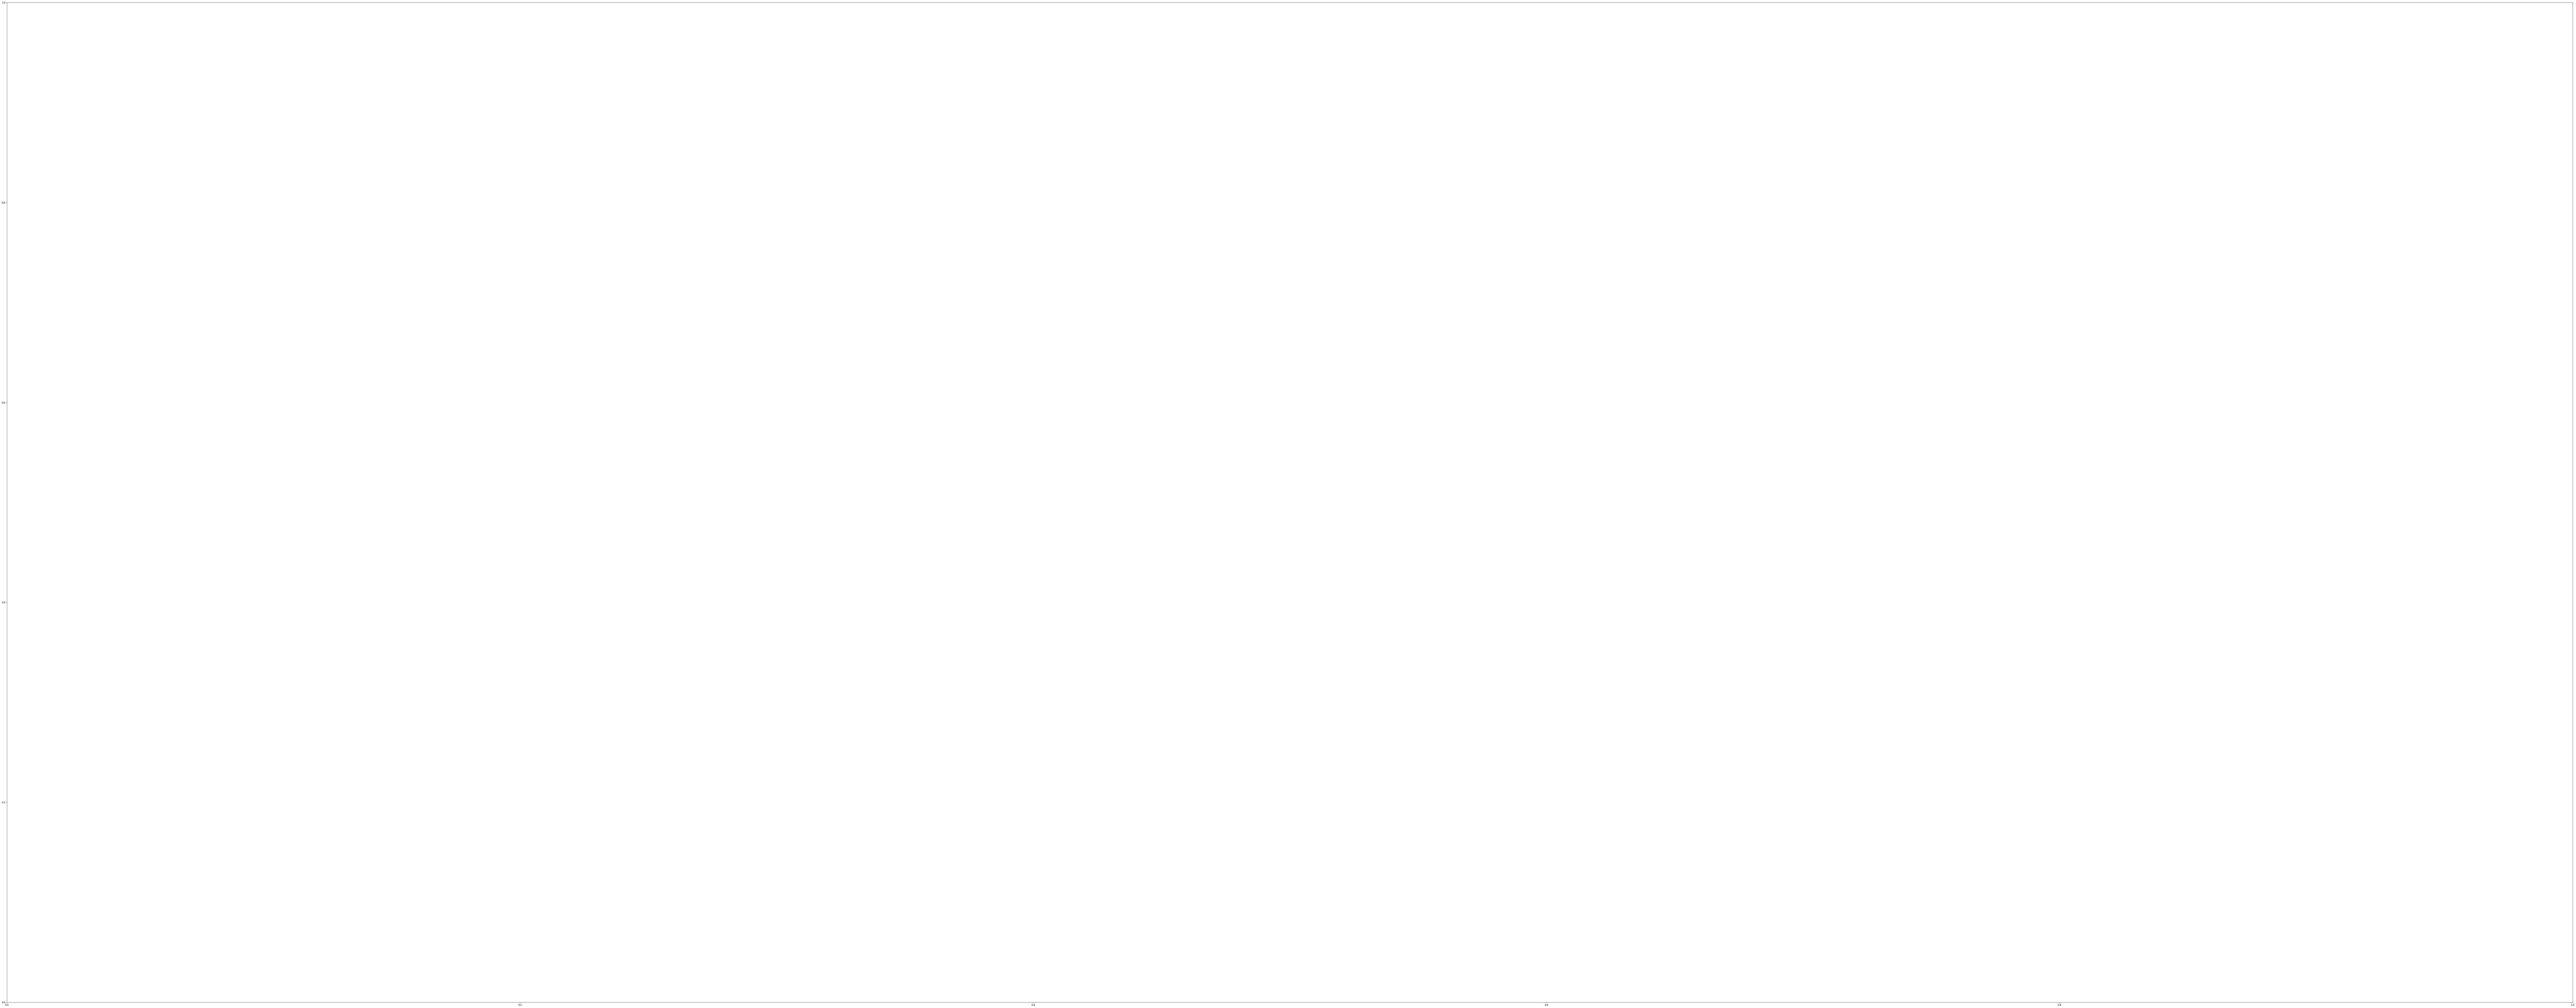

In [63]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [64]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

/usr/local/lib/python3.7/dist-packages/sknetwork/visualization/dendrograms.py:146: RuntimeWarning: invalid value encountered in double_scalars
  x = width_basis - dendrogram[t, 2] * unit_width


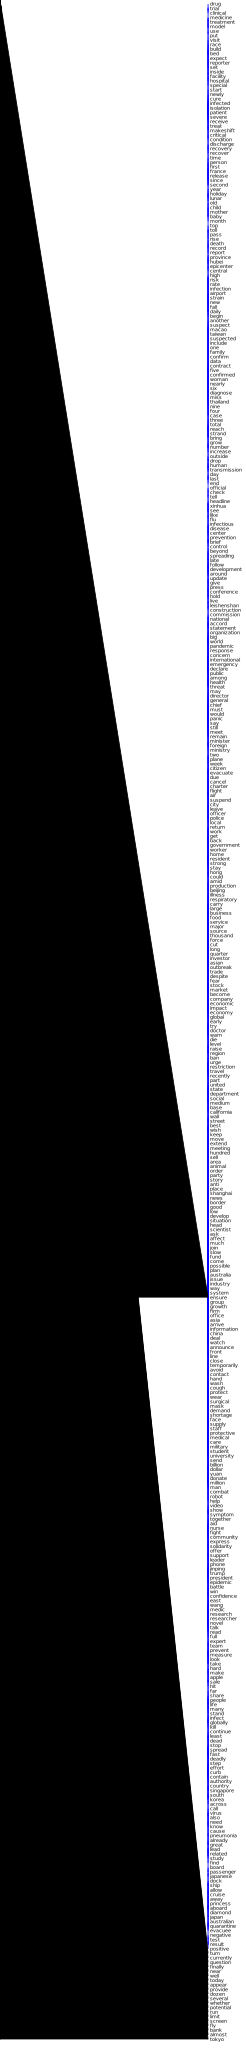

In [65]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

/usr/local/lib/python3.7/dist-packages/sknetwork/visualization/dendrograms.py:146: RuntimeWarning: invalid value encountered in double_scalars
  x = width_basis - dendrogram[t, 2] * unit_width


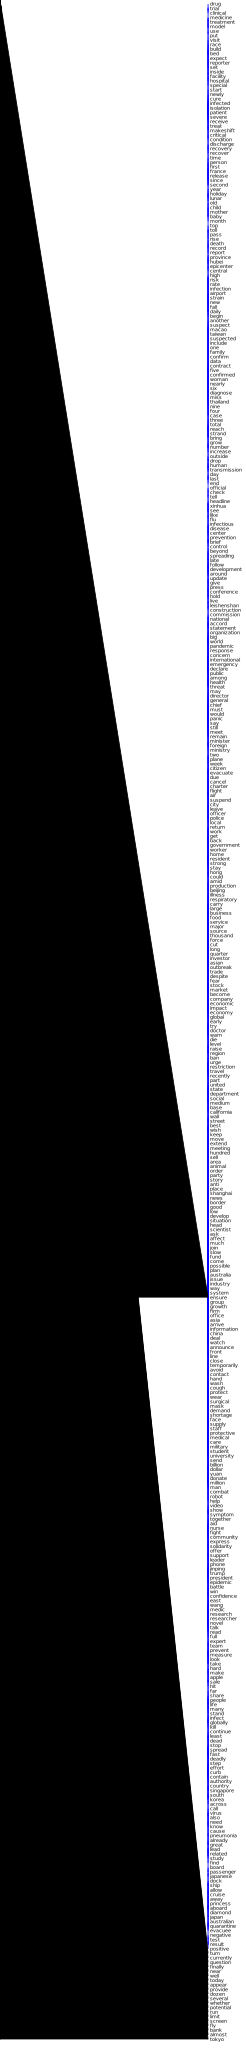

In [68]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.5998770743700061
Performance:  0.5349943110540596
Modularity:  0.1907479504117315


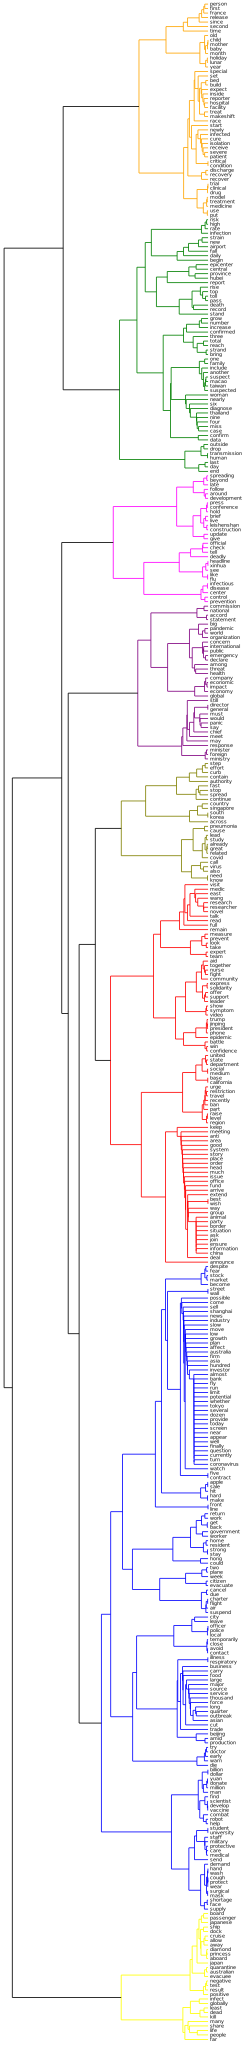

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.3574062692071297
Performance:  0.8125468000894672
Modularity:  0.19691215237768522


### Clique percolation:
Find k-clique communities in graph using the percolation method.

In [138]:
for k in range(2,10):
  cliques = nx.find_cliques(G) 
  community_clique = list(community.k_clique_communities(G, k, cliques))
  print('k =', k)
  print(len(community_clique))

k 2
1
k 3
3
k 4
2
k 5
1
k 6
2
k 7
2
k 8
1
k 9
1


In [139]:
k = 4
cliques = nx.find_cliques(G)
community_clique = list(community.k_clique_communities(G, k, cliques))

In [140]:
community_clique

[frozenset({'aboard',
            'accord',
            'across',
            'aid',
            'already',
            'also',
            'amid',
            'among',
            'announce',
            'another',
            'apple',
            'around',
            'authority',
            'baby',
            'back',
            'battle',
            'become',
            'bed',
            'begin',
            'beijing',
            'beyond',
            'big',
            'board',
            'brief',
            'bring',
            'build',
            'california',
            'call',
            'cancel',
            'case',
            'cause',
            'center',
            'central',
            'check',
            'chief',
            'china',
            'citizen',
            'city',
            'close',
            'combat',
            'commission',
            'community',
            'company',
            'concern',
            'conference',
            'confi

## **SeptOct2020**

### Load data

In [141]:
period = '_SeptOct2020'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

nodes = pd.read_csv('/content/nodelist_China_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [142]:
# Remove search keywords: coronavirus, covid, vaccine
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [143]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  504
Edges:  4592
Is connected:  False

China:
Words:  6219

USA:
Words:  19457


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [73]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

In [74]:
print(community_bipart[0])
print(community_bipart[1])

{'president', 'continue', 'debate', 'analysis', 'response', 'virus', 'call', 'leave', 'remain', 'outside', 'nominee', 'soon', 'concern', 'house', 'become', 'week', 'trillion', 'senator', 'add', 'due', 'talk', 'data', 'game', 'financial', 'hospital', 'senate', 'antibody', 'claim', 'doctor', 'relief', 'travel', 'hope', 'safe', 'breaking', 'condition', 'package', 'vice', 'staff', 'seek', 'provide', 'may', 'mask', 'person', 'give', 'election', 'early', 'food', 'statement', 'stay', 'aid', 'face', 'back', 'include', 'pause', 'supreme', 'make', 'ahead', 'center', 'question', 'economic', 'joe', 'develop', 'tell', 'raise', 'presidential', 'stock', 'top', 'announce', 'expose', 'catch', 'illness', 'post', 'walter', 'court', 'lady', 'race', 'self', 'mark', 'quarantine', 'immune', 'hick', 'least', 'study', 'amy', 'supporter', 'exclusive', 'care', 'congress', 'wear', 'old', 'chief', 'trump', 'international', 'authorization', 'release', 'flight', 'mike', 'feel', 'volunteer', 'receive', 'drug', 'appea

In [75]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [76]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  27 %
USA:  69 %
China&USA:  4 %

China:  41 %
USA:  52 %
China&USA:  7 %


**Metrics**

In [77]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.7147212543554007
Performance:  0.5165514847423396
Modularity:  0.25807457563842034


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [78]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [79]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['president', 'continue', 'analysis', 'call', 'leave', 'remain', 'outside', 'nominee', 'house', 'win', 'become', 'week', 'add', 'senator', 'recover', 'administration', 'game', 'development', 'hospital', 'senate', 'claim', 'doctor', 'travel', 'breaking', 'meet', 'vice', 'staff', 'provide', 'mask', 'person', 'give', 'stay', 'election', 'statement', 'face', 'back', 'include', 'supreme', 'center', 'ahead', 'question', 'joe', 'tell', 'raise', 'activity', 'presidential', 'stock', 'top', 'expose', 'announce', 'post', 'walter', 'court', 'lady', 'despite', 'commission', 'supply', 'self', 'mark', 'quarantine', 'likely', 'loss', 'hick', 'least', 'amy', 'care', 'supporter', 'wear', 'crisis', 'condition', 'chief', 'international', 'hope', 'trump', 'release', 'flight', 'receive', 'mike', 'feel', 'message', 'office', 'reed', 'stop', 'hold', 'right', 'vote', 'still', 'team', 'leader', 'system', 'next', 'contact', 'air', 'push', 'handling', 'small', 'try', 'general', 'base', 'jersey', 'share', 'think',

In [80]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  30 %
USA:  63 %
China&USA:  6 %

Community:  1
China:  51 %
USA:  42 %
China&USA:  7 %

Community:  2
China:  22 %
USA:  76 %
China&USA:  1 %

Community:  3
China:  26 %
USA:  70 %
China&USA:  4 %

Community:  4
China:  7 %
USA:  93 %
China&USA:  0 %

Community:  5
China:  29 %
USA:  57 %
China&USA:  14 %

Community:  6
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  7
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  8
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  9
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  10
China:  0 %
USA:  100 %
China&USA:  0 %



**Metrics**

In [81]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.5764372822299652
Performance:  0.7337877496923223
Modularity:  0.30106386552914055


In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  if node in community_mod_list[5]:
    colors[i] = 'yellow'
    dict_nodes[node] = 5
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [82]:
community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [83]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['daily', 'case', 'infection', 'high', 'since', 'number', 'new', 'hit', 'record', 'italy', 'week', 'report', 'health', 'time', 'increase', 'death', 'month', 'country', 'rise', 'france', 'see', 'expert', 'surpass', 'million', 'toll', 'confirm', 'one', 'resurgence', 'accord', 'ministry', 'register', 'national', 'student', 'university', 'local', 'across', 'pass', 'surge', 'close', 'bring', 'total', 'tally', 'india', 'brazil', 'winter', 'milestone', 'outbreak', 'spread', 'measure', 'past', 'hour', 'city', 'china', 'day', 'state', 'single', 'set', 'york', 'russia', 'qingdao', 'last', 'fall', 'germany', 'start', 'spike', 'two', 'authority', 'six', 'school', 'region', 'gathering', 'restriction', 'seven', 'nine', 'nationwide', 'three', 'nearly', 'bar', 'rate', 'australia', 'low', 'impose', 'french', 'level', 'ease', 'another', 'warn', 'half', 'curb', 'research', 'trend', 'slow', 'medium', 'expect', 'less', 'business', 'mayor', 'hard', 'place', 'holiday', 'restaurant', 'protest', 'governor', 'j

In [84]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  53 %
USA:  41 %
China&USA:  6 %

Community:  1
China:  33 %
USA:  67 %
China&USA:  0 %

Community:  2
China:  32 %
USA:  61 %
China&USA:  6 %

Community:  3
China:  25 %
USA:  70 %
China&USA:  5 %

Community:  4
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  5
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  6
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  7
China:  26 %
USA:  71 %
China&USA:  3 %

Community:  8
China:  0 %
USA:  100 %
China&USA:  0 %



**Metrics**

In [85]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.5267857142857143
Performance:  0.7469626684338414
Modularity:  0.2984292837138494


In [86]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'lightcoral' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [ ]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

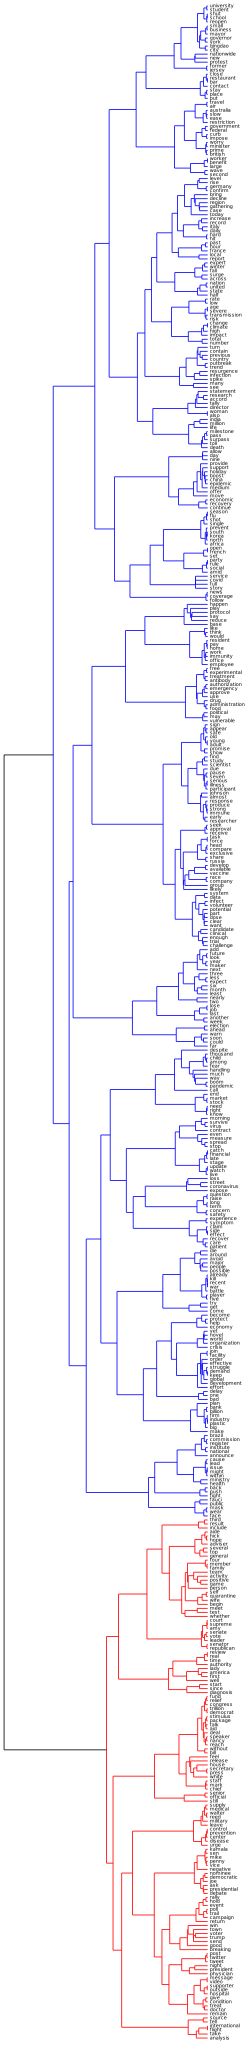

In [ ]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.7335298196948682
Performance:  0.4030840953917877
Modularity:  0.14377128666610495


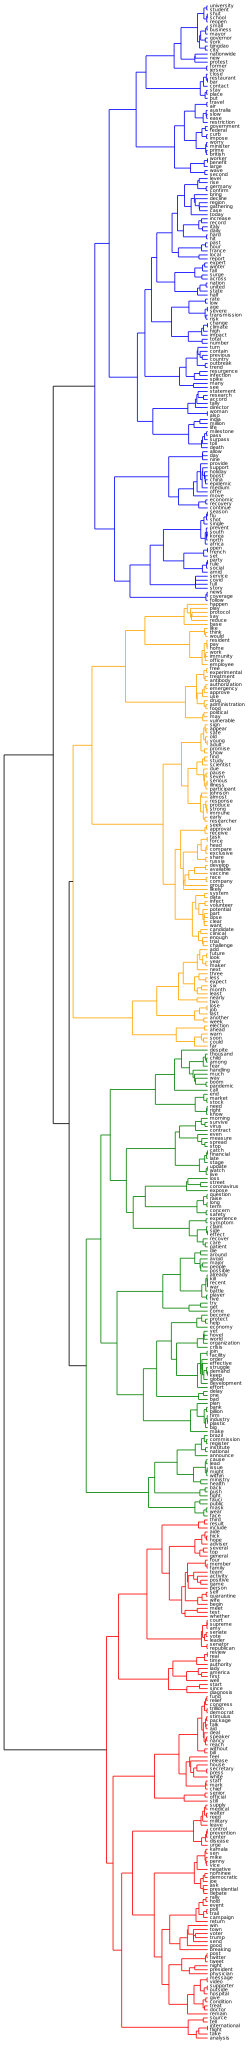

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.4360263522884882
Performance:  0.7424203444270334
Modularity:  0.19129244555448705


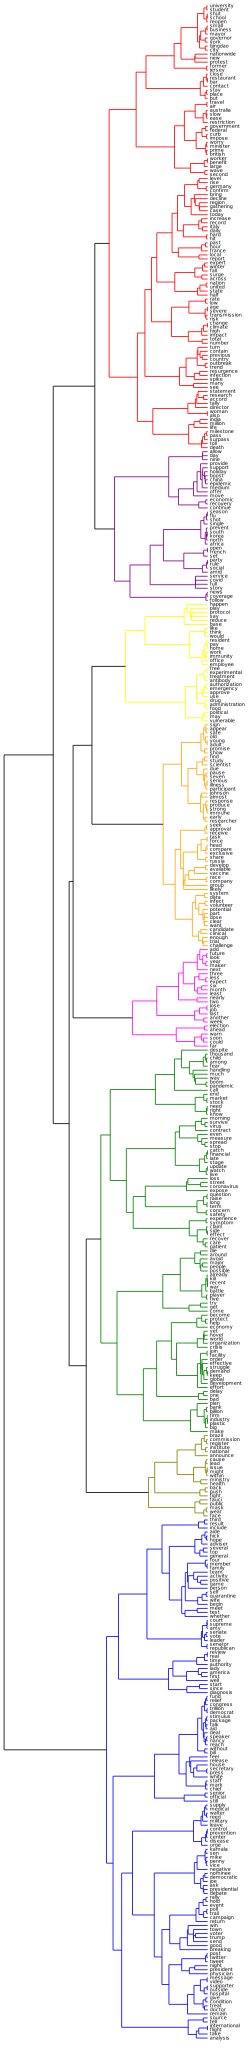

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.3567961165048544
Performance:  0.8137536933523556
Modularity:  0.18146079609215154


### Clique percolation:
Find k-clique communities in graph using the percolation method.

In [144]:
for k in range(2,10):
  cliques = nx.find_cliques(G) 
  community_clique = list(community.k_clique_communities(G, k, cliques))
  print('k =', k)
  print(len(community_clique))

k = 2
1
k = 3
2
k = 4
2
k = 5
2
k = 6
1
k = 7
6
k = 8
7
k = 9
4


In [145]:
k = 8
cliques = nx.find_cliques(G)
community_clique = list(community.k_clique_communities(G, k, cliques))

In [146]:
community_clique

[frozenset({'accord',
            'across',
            'administration',
            'adviser',
            'africa',
            'ahead',
            'aide',
            'also',
            'amid',
            'amy',
            'analysis',
            'announce',
            'around',
            'australia',
            'authority',
            'back',
            'bad',
            'become',
            'begin',
            'big',
            'bill',
            'brazil',
            'call',
            'campaign',
            'candidate',
            'care',
            'case',
            'cause',
            'center',
            'chief',
            'china',
            'city',
            'clear',
            'clinical',
            'close',
            'come',
            'commission',
            'concern',
            'condition',
            'confirm',
            'contact',
            'continue',
            'contract',
            'could',
            'country',
      

## **MarchApril2021**

Load data

In [148]:
period = '_MarchApril2021'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

nodes = pd.read_csv('/content/nodelist_China_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [149]:
# Remove search keywords: coronavirus, covid, vaccine
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [150]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  497
Edges:  2050
Is connected:  False

China:
Words:  5724

USA:
Words:  12540


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [90]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

In [91]:
print(community_bipart[0])
print(community_bipart[1])

{'president', 'continue', 'michigan', 'dos', 'hospitalization', 'health', 'analysis', 'donate', 'africa', 'review', 'virus', 'new', 'total', 'rare', 'call', 'day', 'medicine', 'clot', 'half', 'surpass', 'pandemic', 'across', 'committee', 'young', 'concern', 'record', 'shot', 'become', 'week', 'single', 'due', 'start', 'efficacy', 'fully', 'increase', 'data', 'hospital', 'set', 'see', 'three', 'prevent', 'third', 'travel', 'global', 'safe', 'france', 'meet', 'year', 'foreign', 'may', 'australia', 'regulator', 'mask', 'spike', 'reach', 'agency', 'recommend', 'school', 'give', 'two', 'growth', 'union', 'origin', 'deliver', 'back', 'rise', 'pause', 'state', 'brain', 'six', 'variant', 'make', 'wave', 'economic', 'nation', 'include', 'toll', 'african', 'effective', 'develop', 'russia', 'people', 'germany', 'last', 'top', 'since', 'announce', 'nearly', 'illness', 'commission', 'expand', 'province', 'month', 'supply', 'close', 'vaccinate', 'united', 'many', 'likely', 'animal', 'yunnan', 'least

In [92]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [93]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  41 %
USA:  57 %
China&USA:  2 %

China:  28 %
USA:  65 %
China&USA:  6 %


**Metrics**

In [94]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.8936585365853659
Performance:  0.5141007334328552
Modularity:  0.05055339141977331


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [95]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [96]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['share', 'decide', 'low', 'must', 'review', 'begin', 'effect', 'open', 'benefit', 'allow', 'senior', 'call', 'rare', 'need', 'remain', 'medicine', 'clot', 'age', 'infectious', 'risk', 'committee', 'ask', 'soon', 'concern', 'director', 'shot', 'win', 'add', 'woman', 'due', 'researcher', 'increase', 'impact', 'side', 'level', 'protect', 'executive', 'british', 'blood', 'well', 'safe', 'breaking', 'problem', 'meet', 'emergency', 'consider', 'lead', 'australia', 'may', 'seek', 'possible', 'big', 'safety', 'regulator', 'target', 'source', 'agency', 'recommend', 'investigation', 'give', 'decision', 'protection', 'outweigh', 'part', 'limit', 'union', 'early', 'delay', 'approval', 'deliver', 'back', 'suspend', 'pause', 'brain', 'six', 'nation', 'government', 'plan', 'cause', 'develop', 'germany', 'find', 'top', 'slow', 'resume', 'disorder', 'say', 'follow', 'contract', 'expand', 'within', 'supply', 'many', 'likely', 'even', 'hop', 'economy', 'track', 'exclusive', 'chief', 'authorization', 'li

In [97]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  15 %
USA:  82 %
China&USA:  3 %

Community:  1
China:  53 %
USA:  45 %
China&USA:  1 %

Community:  2
China:  49 %
USA:  46 %
China&USA:  5 %

Community:  3
China:  46 %
USA:  54 %
China&USA:  0 %

Community:  4
China:  20 %
USA:  75 %
China&USA:  5 %

Community:  5
China:  6 %
USA:  88 %
China&USA:  6 %

Community:  6
China:  44 %
USA:  56 %
China&USA:  0 %

Community:  7
China:  43 %
USA:  57 %
China&USA:  0 %

Community:  8
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  9
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  10
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  11
China:  50 %
USA:  50 %
China&USA:  0 %

Community:  12
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  13
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  14
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  15
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  16
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  17
China:  0 %
USA:  100 %
China&USA:  0 %

Com

**Metrics**

In [98]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.58
Performance:  0.8709352891542805
Modularity:  0.3495498894788187


In [99]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  if node in community_mod_list[5]:
    colors[i] = 'yellow'
    dict_nodes[node] = 5
  if node in community_mod_list[6]:
    colors[i] = 'pink'
    dict_nodes[node] = 6
  if node in community_mod_list[7]:
    colors[i] = 'orange'
    dict_nodes[node] = 7
  if node in community_mod_list[8]:
    colors[i] = 'blue'
    dict_nodes[node] = 8
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [101]:
community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [102]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['death', 'toll', 'surpass', 'mark', 'third', 'rise', 'new', 'wave', 'virus', 'brazil', 'number', 'report', 'case', 'month', 'record', 'daily', 'high', 'surge', 'variant', 'pass', 'hit', 'hour', 'bad', 'day', 'bring', 'accord', 'set', 'see', 'nation', 'state', 'city', 'restriction', 'amid', 'infection', 'rate', 'south', 'average', 'every', 'india', 'spread', 'spike', 'news', 'confirm', 'three', 'since', 'michigan', 'study', 'event', 'province', 'hard', 'five', 'overseas', 'ease', 'major', 'nearly', 'institute', 'african', 'double', 'united', 'strain', 'york', 'seven', 'local', 'fear', 'yunnan', 'ever', 'single', 'origin', 'decline', 'another', 'cite', 'update', 'fourth', 'block', 'suffer', 'korea', 'analysis', 'coverage']
['ship']
['grow']
['beach']
['health', 'world', 'global', 'ministry', 'expert', 'top', 'far', 'around', 'public', 'authority', 'organization', 'warn', 'official', 'watch', 'register', 'fund', 'economic', 'international', 'crisis', 'worker', 'call', 'russia', 'animal',

In [103]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  49 %
USA:  47 %
China&USA:  4 %

Community:  1
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  2
China:  0 %
USA:  0 %
China&USA:  100 %

Community:  3
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  4
China:  44 %
USA:  56 %
China&USA:  0 %

Community:  5
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  6
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  7
China:  0 %
USA:  0 %
China&USA:  100 %

Community:  8
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  9
China:  27 %
USA:  70 %
China&USA:  3 %

Community:  10
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  11
China:  45 %
USA:  53 %
China&USA:  1 %

Community:  12
China:  100 %
USA:  0 %
China&USA:  0 %

Community:  13
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  14
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  15
China:  30 %
USA:  65 %
China&USA:  4 %

Community:  16
China:  0 %
USA:  100 %
China&USA:  0 %

Community:  17
China:  100 %
USA:  0 %
China&USA:  0 %

Co

**Metrics**

In [104]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.5248780487804878
Performance:  0.8865369637177906
Modularity:  0.35496369298868075


In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [ ]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

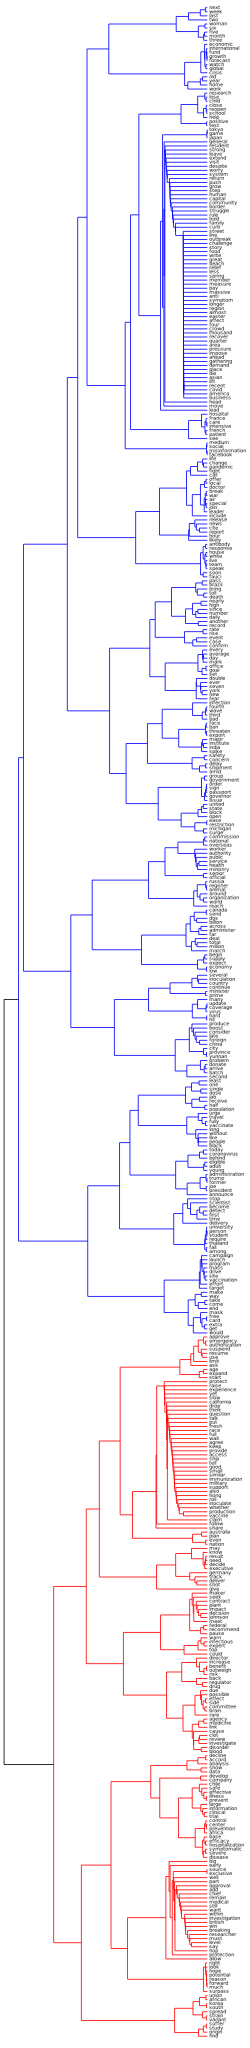

In [ ]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.6845593108018555
Performance:  0.46240480961923847
Modularity:  0.12028408143658839


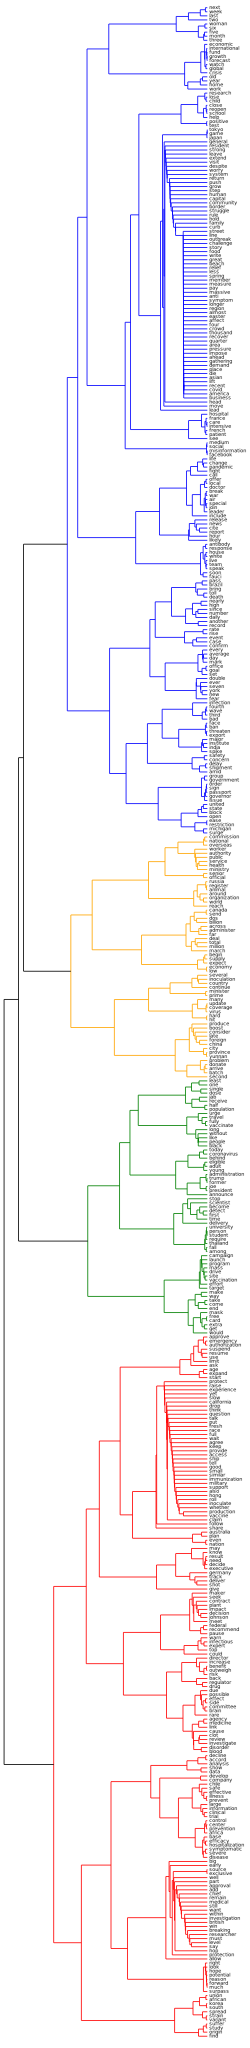

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.5056328694499669
Performance:  0.685186372745491
Modularity:  0.16074707423058626


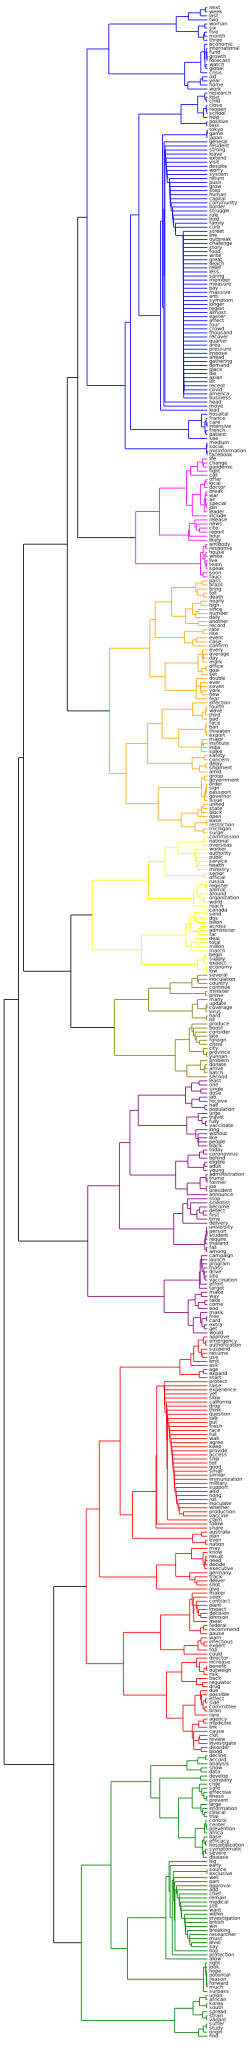

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.37773359840954274
Performance:  0.8417795591182364
Modularity:  0.15233192234402027


### Clique percolation:
Find k-clique communities in graph using the percolation method.

In [151]:
for k in range(2,10):
  cliques = nx.find_cliques(G) 
  community_clique = list(community.k_clique_communities(G, k, cliques))
  print('k =', k)
  print(len(community_clique))

k = 2
1
k = 3
4
k = 4
4
k = 5
2
k = 6
5
k = 7
5
k = 8
4
k = 9
2


In [153]:
k = 7
cliques = nx.find_cliques(G)
community_clique = list(community.k_clique_communities(G, k, cliques))

In [154]:
community_clique

[frozenset({'accord',
            'across',
            'administer',
            'adult',
            'africa',
            'age',
            'agency',
            'amid',
            'announce',
            'approve',
            'batch',
            'blood',
            'brazil',
            'case',
            'china',
            'city',
            'clot',
            'commission',
            'concern',
            'could',
            'country',
            'daily',
            'data',
            'day',
            'death',
            'develop',
            'disease',
            'dos',
            'dose',
            'drug',
            'emergency',
            'expert',
            'fauci',
            'federal',
            'find',
            'first',
            'germany',
            'get',
            'give',
            'global',
            'goal',
            'government',
            'health',
            'high',
            'hit',
            'hospital',
        